<a href="https://colab.research.google.com/github/Gehlen05/sms-classifier-senior-sistemas/blob/main/sms_classifier_regressao_logistica_floresta_decisao_token_senior_sistemas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importacoes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from ast import increment_lineno
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer

### Leitura arquivo
Projeto foi montado para rodar no colab, podendo ser rodado em outras interfaces. Porem deve se atentar aos diretorios. Para o projeto executar corretamente o arquivo sms_senior.csv devera estar na pasta do drive Colab Notebooks junto com o projeto. Caso opte por rodar na maquina no jupyter devera ser mudado o caminho.

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sms_senior.csv',  encoding= 'unicode_escape', delimiter=',')
df.head()

Mounted at /content/drive


,Full_Text,got,great,wat,free,text,txt,win,already,dun,...,number,wish,leave,thing,many,wan,Common_Word_Count,Word_Count,Date,IsSpam
0,Hey! Congrats 2u2. id luv 2 but ive had 2 go h...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,12,2017-01-01 00:08:00,no
1,"came to look at the flat, seems ok, in his 50s...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,23,2017-01-01 00:19:00,no
2,Urgent! call 09061749602 from Landline. Your c...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,25,2017-01-01 01:53:00,yes
3,Do you hide anythiing or keeping distance from me,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,9,2017-01-01 02:14:00,no
4,"Actually, my mobile is full of msg. And i m do...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,9,29,2017-01-01 02:25:00,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Columns: 154 entries, Full_Text to IsSpam
dtypes: int64(151), object(3)
memory usage: 6.5+ MB


### Mapa
Mapa de distribuicao de Comun e Spam.

0    4827
1     747
Name: IsSpam, dtype: int64


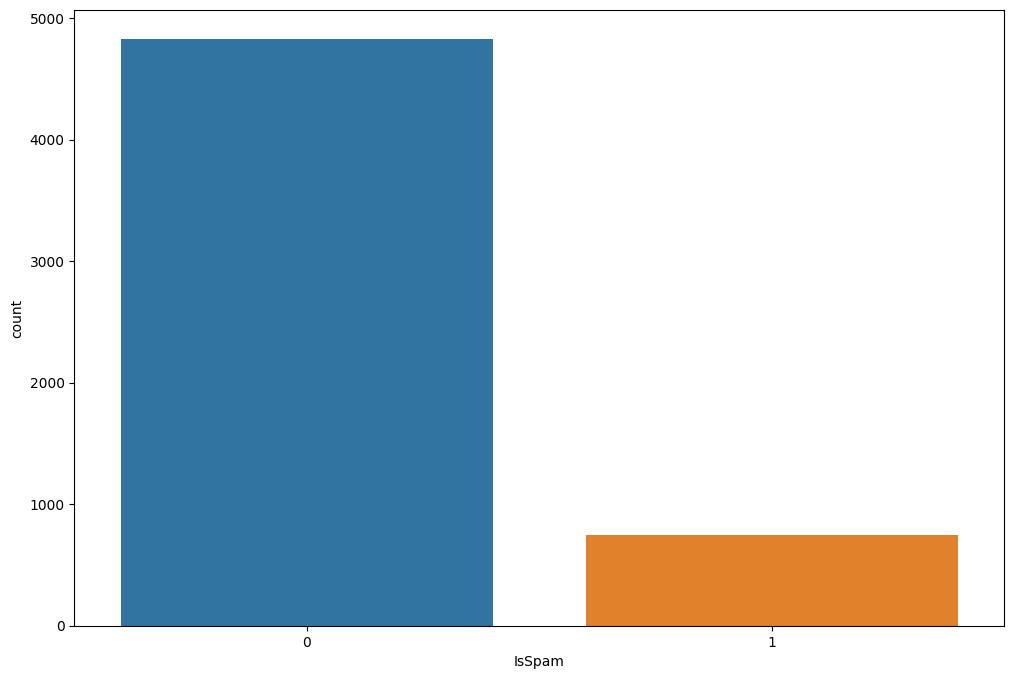

In [23]:
ax = sns.countplot(x='IsSpam',data=df)
print(df['IsSpam'].value_counts())

Mapa de calor entre as colunas.

<ipython-input-22-4282f1d26b61>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr());


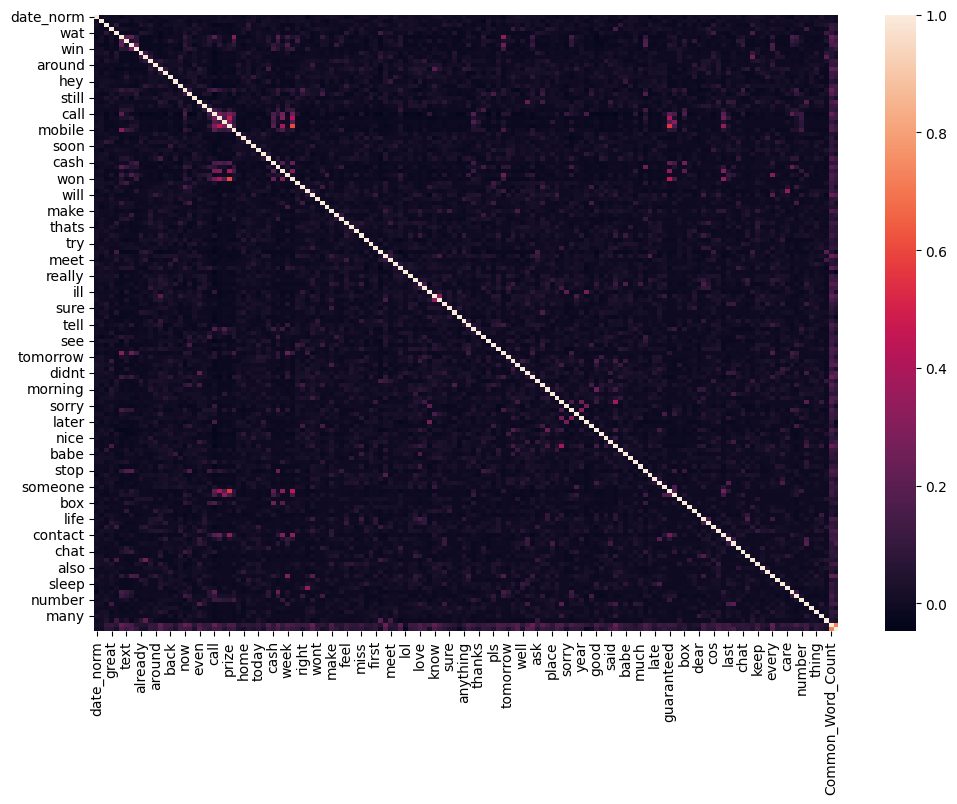

In [22]:
f, ax = plt.subplots()
sns.heatmap(df.corr());

### Separacao e normalizacao
O campo Date foi seprado e transformado em string.

In [6]:
df['scaled_date'] = pd.to_datetime(df['Date'])
df['scaled_time'] = pd.to_datetime(df['Date'])
df['scaled_date'] = df['scaled_date'].dt.strftime('%Y%m%d')
df['scaled_time'] =  df['scaled_time'].dt.strftime('%H%M%s')

Colunas foram normalizadas para nao ter discrepancia de valores.

In [7]:
rob_scaler = RobustScaler()
df['scaled_time'] = rob_scaler.fit_transform(df['scaled_time'].values.reshape(-1,1))
df['scaled_date'] = rob_scaler.fit_transform(df['scaled_date'].values.reshape(-1,1))
df['Common_Word_Count'] = rob_scaler.fit_transform(df['Common_Word_Count'].values.reshape(-1,1))
df['Word_Count'] = rob_scaler.fit_transform(df['Word_Count'].values.reshape(-1,1))
df.loc[df.IsSpam=='no','IsSpam']='0'
df.loc[df.IsSpam=='yes','IsSpam']='1'

### Tokenizacao e concatenacao
Na sequencia foi tokenizado o campo Full_Text do arquivo de entrada

In [8]:
df.insert(1, 'date_norm', df['scaled_date'])
df.insert(2, 'time_norm', df['scaled_time'])

In [9]:
df.drop(['time', 'scaled_date', 'scaled_time', 'Date', 'Full_Text'], axis=1, inplace=True)

Concatenando o df de entrad ja modificado e o df gerado a partir da tokenizacao

In [10]:
df.head()

,date_norm,time_norm,got,great,wat,free,text,txt,win,already,...,phone,number,wish,leave,thing,many,wan,Common_Word_Count,Word_Count,IsSpam
0,-0.607527,-1.011636,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.333333,-0.0625,0
1,-0.607527,-1.002328,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.333333,0.6250,0
2,-0.607527,-0.888936,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.666667,0.7500,1
3,-0.607527,-0.837318,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.666667,-0.2500,0
4,-0.607527,-0.828010,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2.333333,1.0000,0


### Separando entrada e saida para os modelos

In [11]:
x = df.iloc[:, 0:-1].values
y = df.iloc[:, -1].values

Dividindo a entrada e saida em treino e teste

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

### Regressao logistica
  O primeiro modelo aplicado foi o de regressao logistica que classifica os sms.
  
  Unica alteraca foi na quantidade de iteracoes

In [13]:
lr = LogisticRegression(max_iter=300, random_state=42)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print('Acurácia: ', metrics.accuracy_score(y_test, y_pred))
print('Precisão: ', metrics.precision_score(y_test, y_pred, average='macro'))
print('Recall: ', metrics.recall_score(y_test, y_pred, average='macro'))
print('F1: ', metrics.f1_score(y_test, y_pred, average='macro'))

Acurácia:  0.9739910313901345
Precisão:  0.9649110309017224
Recall:  0.9175968716672591
F1:  0.9394771469375456


Matriz confusao resultou:

TP: 964 classificados corretamente como sms comun

FN: 6 classificados incoretamente como sms spam

FP: 23 classificados incorretamente como sms comun

TN: 122 classificados coretamente como sms spam

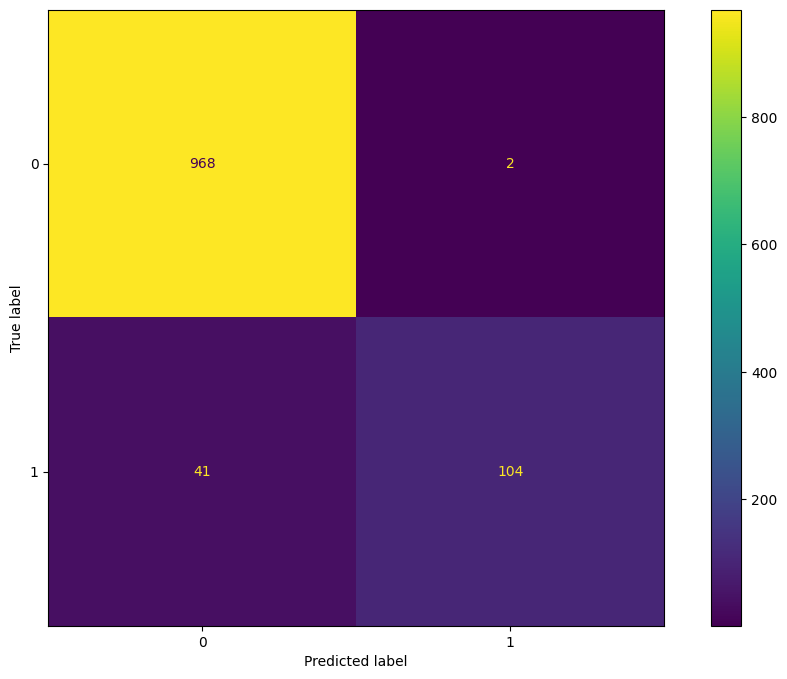

In [21]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

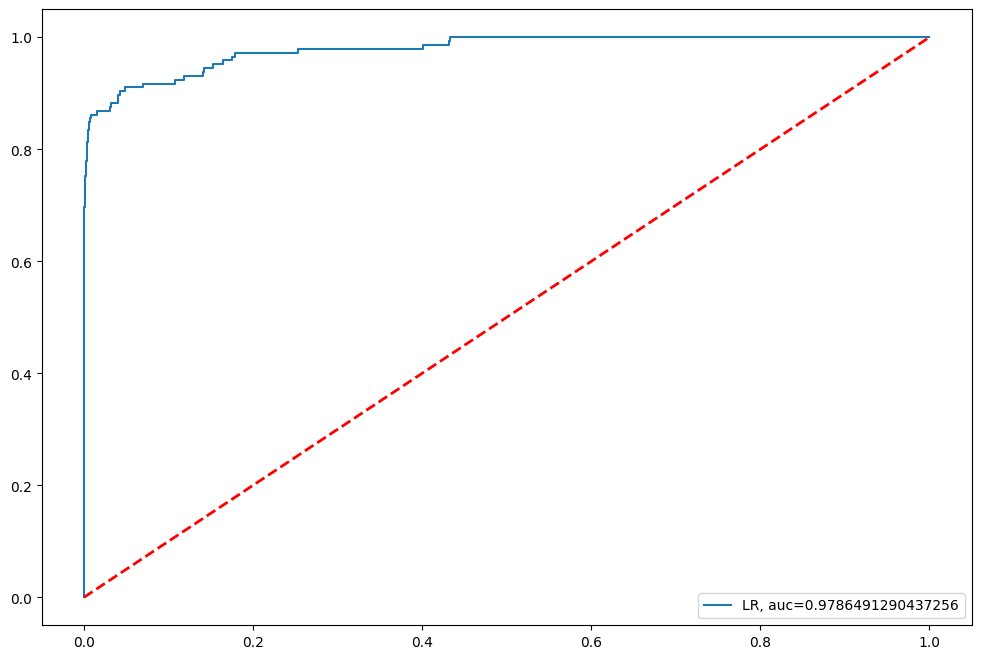

In [15]:
y_pred = y_pred.astype(int)
y_test = y_test.astype(int)
y_pred_proba = lr.predict_proba(x_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr, tpr, label ="LR, auc="+str(auc))
plt.plot([0,1], [0,1], color='red', lw=2, linestyle ='--')
plt.legend(loc=4)

### Floresta de Decisoes
  Por ultimo foi implementado floresta de decisoes.

  Ela foi implementada com profundidade 12 e 100 arvores que vem por padrao.

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [17]:
rf = RandomForestClassifier(max_depth = 12, random_state=42)

In [18]:
model = rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

print('Acurácia: ', metrics.accuracy_score(y_test, y_pred))
print('Precisão: ', metrics.precision_score(y_test, y_pred, average='macro'))
print('Recall: ', metrics.recall_score(y_test, y_pred, average='macro'))
print('F1: ', metrics.f1_score(y_test, y_pred, average='macro'))


Acurácia:  0.9614349775784753
Precisão:  0.9702488920470482
Recall:  0.8575897618201209
F1:  0.9034785567180494


Matriz confusao resultou:

TP: 968 classificados corretamente como sms comun

FN: 2 classificados incoretamente como sms spam

FP: 41 classificados incorretamente como sms comun

TN: 104 classificados coretamente como sms spam


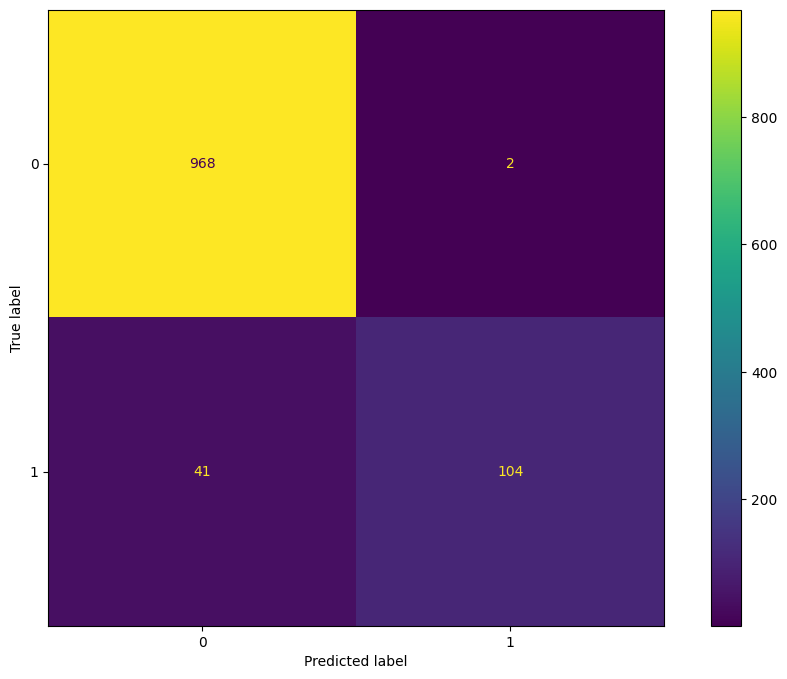

In [19]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

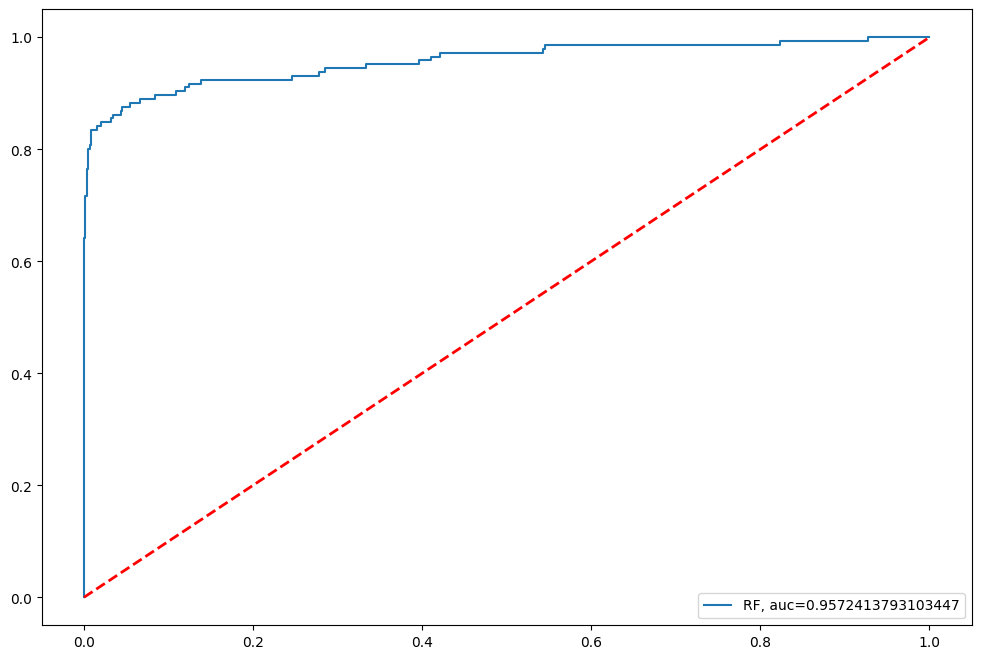

In [20]:
y_pred = y_pred.astype(int)
y_test = y_test.astype(int)

y_pred_proba = rf.predict_proba(x_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr, tpr, label ="RF, auc="+str(auc))
plt.plot([0,1], [0,1], color='red', lw=2, linestyle ='--')
plt.legend(loc=4)